## Load modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 113 GB / percent used: 10.3 %


## Load model data

In [2]:
# Define period
period = slice('1981','2014')

In [3]:
# Variable
var = 'tas'

if var in ['tas']:
    table = 'Amon'

In [4]:
# Load historical
da_historical = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load amip
da_amip = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/amip/r1i1p1f1/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load land-hist
da_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/IPSL/IPSL-CM6A-LR/land-hist/r1i1p1f1/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

In [5]:
# Load HighResMIP
da_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/IPSL/IPSL-CM6A-ATM-HR/highresSST-present/r1i1p1f1/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]
da_HR

<xarray.DataArray 'tas' (time: 408, lat: 361, lon: 512)>
dask.array<getitem, shape=(408, 361, 512), dtype=float32, chunksize=(408, 361, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 0.0 0.703125 1.40625 ... 358.59375 359.29688
    height   float64 ...
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       air_temperature
    description:         Near-Surface Air Temperature
    long_name:           Near-Surface Air Temperature
    history:             none
    units:               K
    cell_measures:       area: areacella

## Load obs 
Attention en °C

In [6]:
obs = xr.open_mfdataset(
    '/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.*.tmp.dat.nc', combine='nested', concat_dim='time'
).isel(
    time=slice(1080,1488)
).tmp
obs

<xarray.DataArray 'tmp' (time: 408, lat: 360, lon: 720)>
dask.array<getitem, shape=(408, 360, 720), dtype=float32, chunksize=(408, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1981-01-16 1981-02-15 ... 2014-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 
obs + HR

In [7]:
# Make the regrider
regridder_obs = xe.Regridder(obs, da_historical, 'bilinear', periodic=True)
regridder_obs

Overwrite existing file: bilinear_360x720_143x144_peri.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_360x720_143x144_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (360, 720) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [8]:
# Regrid the data
obs_regrid = regridder_obs(obs)

In [9]:
# Regrid HighResMIP
regridder_HR = xe.Regridder(da_HR, da_historical, 'bilinear', periodic=True)
regridder_HR

Overwrite existing file: bilinear_361x512_143x144_peri.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x512_143x144_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (361, 512) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [10]:
# Regrid the data
da_HR_regrid = regridder_HR(da_HR)

## Annual Climatology

In [11]:
da_historical_clim = u.clim(da_historical)
da_historical_clim.load()

da_amip_clim = u.clim(da_amip)
da_amip_clim.load()

da_land_hist_clim = u.clim(da_land_hist)
da_land_hist_clim.load()

obs_regrid_clim = u.clim(obs_regrid)
obs_regrid_clim.load()

da_HR_regrid_clim = u.clim(da_HR_regrid)
da_HR_regrid_clim.load()

<xarray.DataArray (lat: 143, lon: 144)>
array([[222.60601027, 222.60601027, 222.60601027, ..., 222.60601027,
        222.60601027, 222.60601027],
       [223.83710769, 223.75769107, 223.67610714, ..., 224.00801178,
        223.95048942, 223.89538481],
       [224.71583691, 224.52909939, 224.34831869, ..., 225.27368456,
        225.08876336, 224.90382298],
       ...,
       [257.69657042, 257.71809574, 257.73945296, ..., 257.62329174,
        257.6511605 , 257.67557259],
       [257.43398159, 257.44407328, 257.45365872, ..., 257.40299762,
        257.41481156, 257.42652087],
       [256.77828045, 256.77828045, 256.77828045, ..., 256.77828045,
        256.77828045, 256.77828045]])
Coordinates:
    height   float64 2.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
Attributes:
    regrid_method:  bilinear

In [14]:
concat = xr.combine_nested(
    [
        (da_historical_clim-273.15)-obs_regrid_clim,
        (da_amip_clim-273.15)-obs_regrid_clim,
        (da_land_hist_clim-273.15)-obs_regrid_clim,
        (da_HR_regrid_clim-273.15)-obs_regrid_clim
    ],
    concat_dim='diff'
)

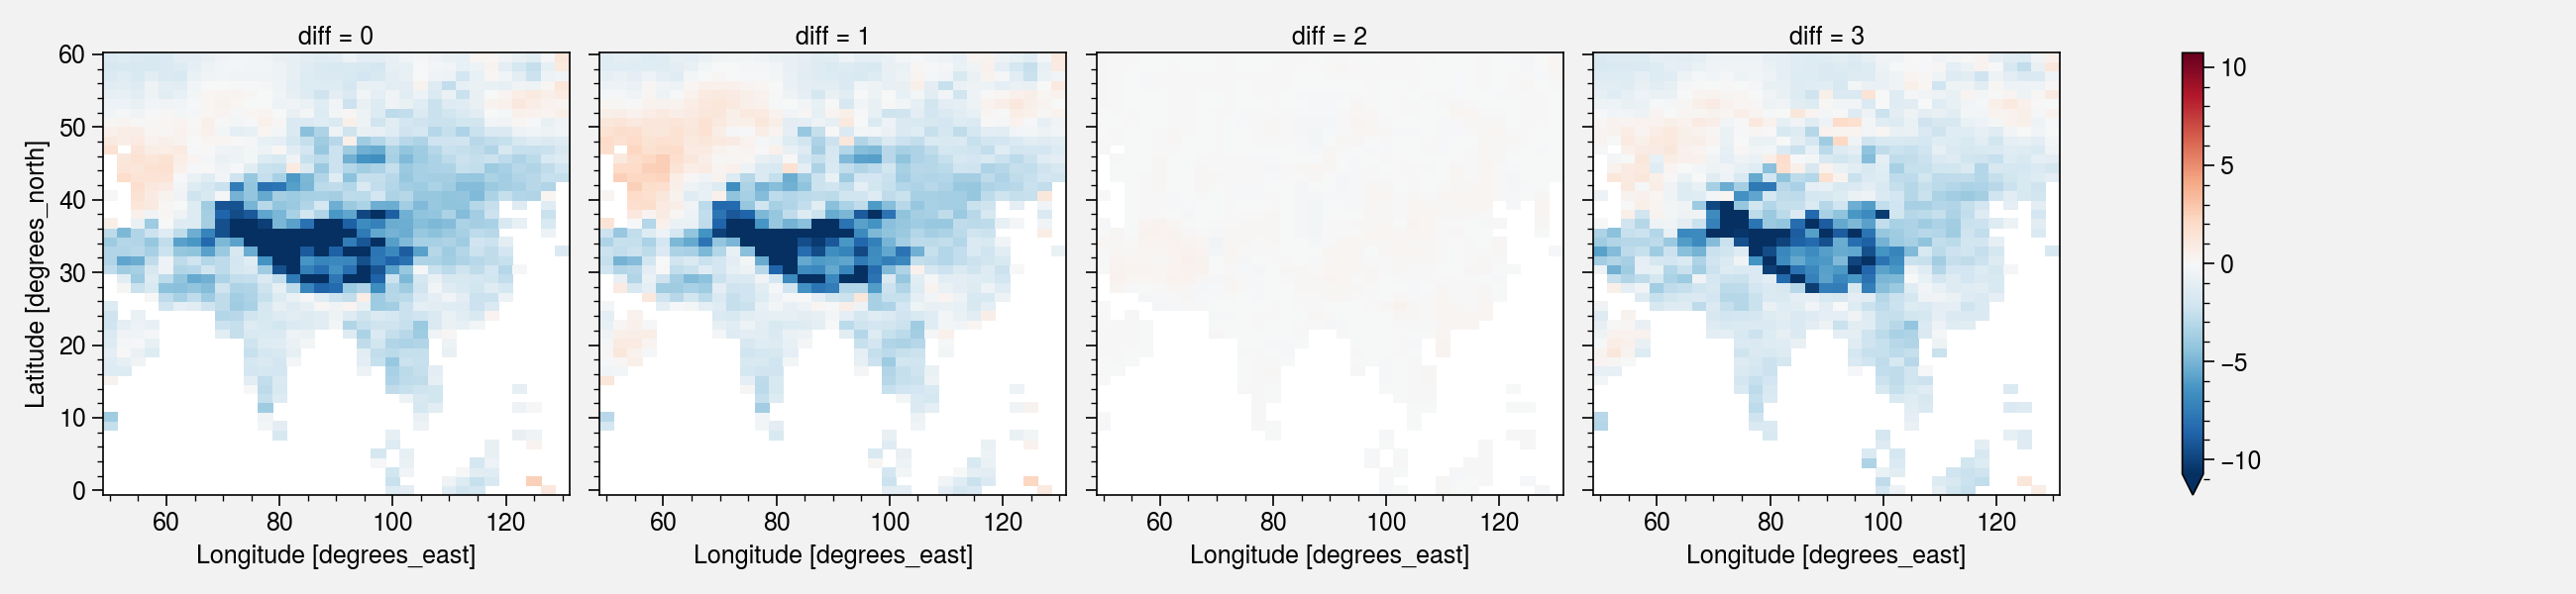

In [39]:
concat.sel(lat=slice(0,60), lon=slice(50,130)).plot(col='diff', robust=True)

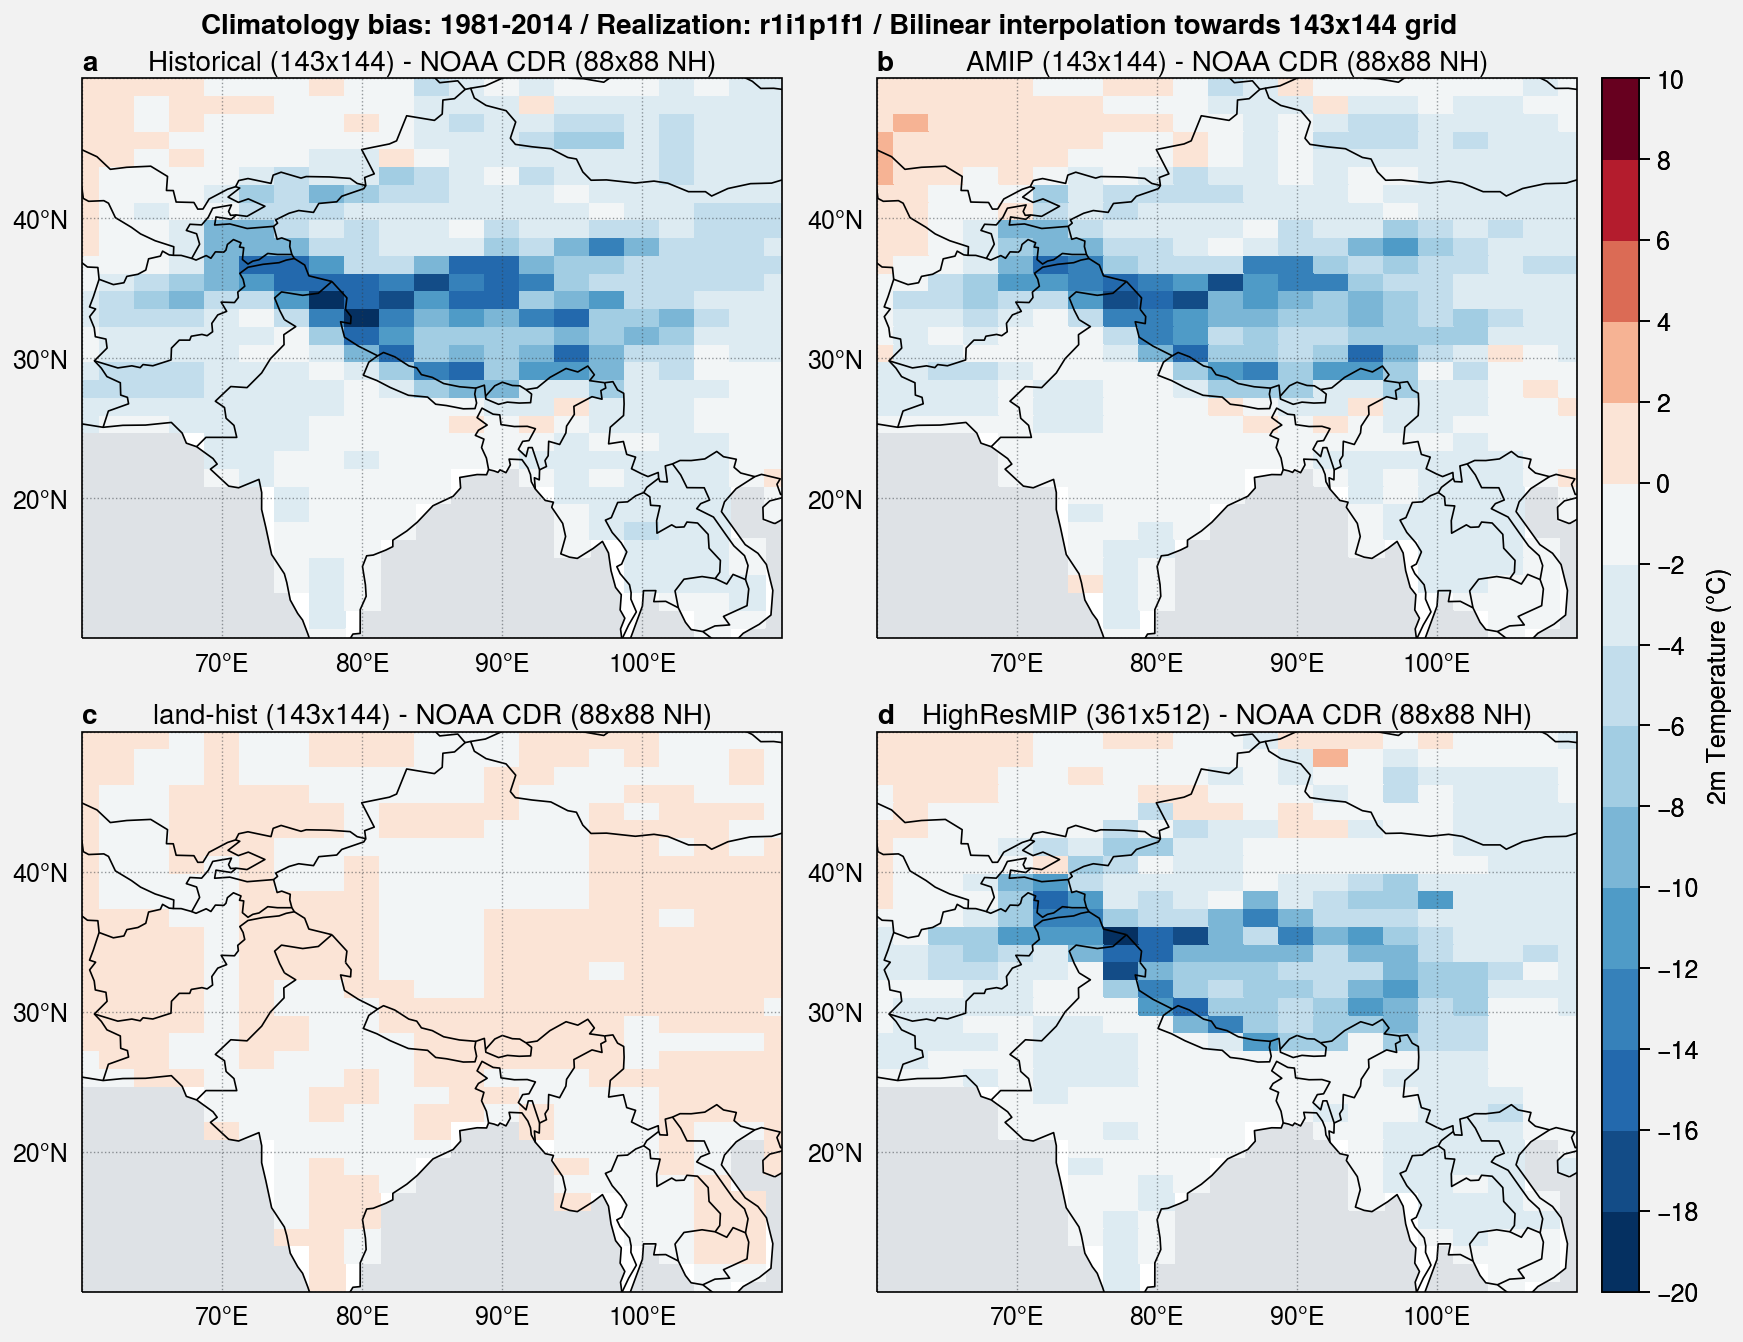

In [37]:
# Differences from Rutger
f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=3.5)

cmap='RdBu_r'
levels=plot.arange(-20,10,2)

m = axs[0].pcolormesh((da_historical_clim-273.15)-obs_regrid_clim, cmap=cmap, 
                      levels=levels, 
#                       extend='both',
                      norm='midpoint'
                     )
axs[0].format(title='Historical (143x144) - NOAA CDR (88x88 NH)')
axs[1].pcolormesh((da_amip_clim-273.15)-obs_regrid_clim, cmap=cmap, 
                  levels=levels, 
#                   extend='both',
                  norm='midpoint'
                 )
axs[1].format(title='AMIP (143x144) - NOAA CDR (88x88 NH)')
axs[2].pcolormesh((da_land_hist_clim-273.15)-obs_regrid_clim, cmap=cmap, 
                  levels=levels, 
#                   extend='both',
                  norm='midpoint'
                 )
axs[2].format(title='land-hist (143x144) - NOAA CDR (88x88 NH)')
axs[3].pcolormesh((da_HR_regrid_clim-273.15)-obs_regrid_clim, cmap=cmap, 
                  levels=levels, 
#                   extend='both',
                  norm='midpoint'
                 )
axs[3].format(title='HighResMIP (361x512) - NOAA CDR (88x88 NH)')

f.colorbar(m, label='2m Temperature (°C)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Climatology bias: 1981-2014 / Realization: r1i1p1f1 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=10, abc=True, latlim=(10,50), lonlim=(60,110)
)

# f.save('bias_hist_amip_land.png')